# **Klasifikasi LDA**

In [1]:
!pip install Sastrawi
!pip install gensim

In [8]:
## FASE 1: SETUP DAN PEMUATAN DATA

# Import library dasar
import pandas as pd
import numpy as np
import re
import time
import re
import string

# Import untuk Preprocessing
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from ast import literal_eval # Untuk mengubah string '[...]' menjadi list

# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

# Import untuk Klasifikasi & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Import untuk Visualisasi
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import umap.umap_ as umap

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# --- Memuat Dataset ---
# Kini membaca file hasil preprocessing yang berisi kolom: isi, hasil_preprocessing, kategori
try:
    df = pd.read_csv('dataset_berita.csv')
    print(f"\nDataset berhasil dimuat. Jumlah data: {len(df)} baris.")
    print("Contoh kolom inti:")
    print(df)
except FileNotFoundError:
    print("\nError: File tidak ditemukan. Pastikan nama file CSV sudah benar.")
    # Jika file tidak ditemukan, hentikan proses.
    # df = pd.DataFrame()


Dataset berhasil dimuat. Jumlah data: 3000 baris.
Contoh kolom inti:
        ID                                              Title  \
0        1  Hasil PSU Serang: Ratu Zakiyah Istri Mendes Ka...   
1        2  Wiranto Ungkap Respons Prabowo soal Usulan Pur...   
2        3  Musisi Rayen Pono Laporkan Ahmad Dhani ke MKD DPR   
3        4  Marak Aksi Premanisme, DPR Desak Pemerintah Bu...   
4        5  Komisi II DPR Soroti Potensi RUU ASN Perluas K...   
...    ...                                                ...   
2995  2996  Gibran Soroti Anak Muda Masa Kini Tak Suka Ker...   
2996  2997  Ahok Hadiri Konser Salam Metal Ganjar-Mahfud d...   
2997  2998  Gibran Sindir Warga yang Tolak Pembangunan: Ke...   
2998  2999  Megawati Pukul Kentungan di GBK Hari Ini, Simb...   
2999  3000  Ratusan LSM dan Tokoh Masyarakat Ramai-ramai B...   

                                                Content Category  
0     Ratu Zakiyah, istri dari Menteri Desa dan PDTY...  Politik  
1     Penasihat

In [16]:
# --- 1. Fungsi Cleaning Teks ---
def clean_text(text):
    if pd.isna(text):  # cek jika NaN
        return ''
    text = text.lower()  # ubah ke huruf kecil
    text = re.sub(r'\d+', '', text)  # hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = re.sub(r'\W', ' ', text)  # hapus karakter non-huruf
    text = BeautifulSoup(text, "html.parser").get_text()  # hapus tag HTML
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi berlebih
    return text

# --- 2. Fungsi Tokenisasi ---
def tokenize_text(text):
    return word_tokenize(text)

# --- 3. Fungsi Stopword Removal ---
list_stopwords = set(stopwords.words('indonesian'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in list_stopwords]

# --- 4. Fungsi Stemming ---
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# --- 5. Baca Dataset ---
df = pd.read_csv('dataset_berita.csv')

# Pastikan kolom bernama 'Cleaning' ada di dataset
# Jika nama kolom lain, sesuaikan di sini
df['cleaned'] = df['Content'].apply(clean_text)
df['tokenized'] = df['cleaned'].apply(tokenize_text)
df['no_stopwords'] = df['tokenized'].apply(remove_stopwords)

# --- 6. Simpan hasil ke file baru ---
# hasil bersih
df.to_csv('berita_preprosesing.csv', index=False)

# --- 7. Tampilkan 5 data awal ---
print(df.head(5))


   ID                                              Title  \
0   1  Hasil PSU Serang: Ratu Zakiyah Istri Mendes Ka...   
1   2  Wiranto Ungkap Respons Prabowo soal Usulan Pur...   
2   3  Musisi Rayen Pono Laporkan Ahmad Dhani ke MKD DPR   
3   4  Marak Aksi Premanisme, DPR Desak Pemerintah Bu...   
4   5  Komisi II DPR Soroti Potensi RUU ASN Perluas K...   

                                             Content Category  \
0  Ratu Zakiyah, istri dari Menteri Desa dan PDTY...  Politik   
1  Penasihat khusus Presiden bidang politik dan k...  Politik   
2  Musisi Rayandie Rohy Pono alias Rayen Pono mel...  Politik   
3  Wakil Ketua Komisi VII DPR Evita Nursantymende...  Politik   
4  Wakil Ketua Komisi II DPR RI Zulfikar Arse Sad...  Politik   

                                             cleaned  \
0  ratu zakiyah istri dari menteri desa dan pdtya...   
1  penasihat khusus presiden bidang politik dan k...   
2  musisi rayandie rohy pono alias rayen pono mel...   
3  wakil ketua komisi vi


Kamus dibuat dan difilter. Jumlah kata unik: 3655

--- Menjalankan HDP untuk estimasi jumlah topik... ---


✅ HDP mengestimasi ada sekitar: 20 topik.

--- Menjalankan pencarian koherensi dari 5 hingga 40 topik... ---
Selesai menghitung untuk 5 topik...
Selesai menghitung untuk 10 topik...
Selesai menghitung untuk 15 topik...
Selesai menghitung untuk 20 topik...
Selesai menghitung untuk 25 topik...
Selesai menghitung untuk 30 topik...
Selesai menghitung untuk 35 topik...

Total waktu pencarian koherensi: 6.91 menit


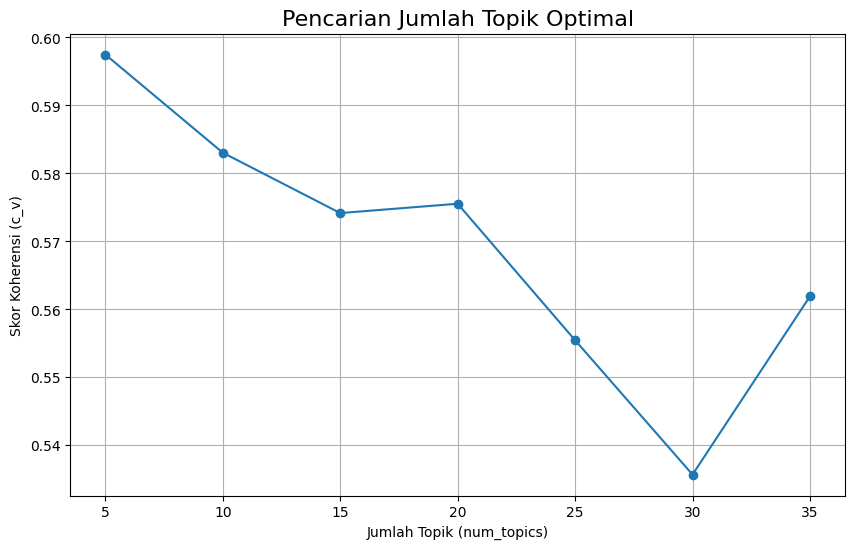


✅ Jumlah topik optimal yang ditemukan: 5

--- Melatih model LDA final dengan topik optimal... ---
Ekstraksi fitur LDA selesai.
Bentuk matriks fitur (X): (3000, 5)


In [17]:
## FASE 3: EKSTRAKSI FITUR LDA & PENCARIAN TOPIK OPTIMAL

# Siapkan data untuk Gensim
documents = df['no_stopwords'].tolist()
dictionary = Dictionary(documents)

# --- A. Filter Kamus (Sesuai Referensi & Praktik Terbaik) ---
# Membuang kata yang terlalu jarang atau terlalu sering muncul.
# Ini meningkatkan kualitas topik secara signifikan.
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f"\nKamus dibuat dan difilter. Jumlah kata unik: {len(dictionary)}")


# --- B. Estimasi Jumlah Topik dengan HDP (Langkah Cerdas) ---
print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
estimated_num_topics = len(hdp_model.print_topics())
print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")


# --- C. Mencari Jumlah Topik Terbaik dengan Plot Koherensi ---
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    start_time = time.time()
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=42, passes=10, workers=3)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Selesai menghitung untuk {num_topics} topik...")
    total_time = time.time() - start_time
    print(f"\nTotal waktu pencarian koherensi: {total_time/60:.2f} menit")
    return coherence_values

# Atur rentang pencarian di sekitar hasil HDP
search_start = max(2, estimated_num_topics - 15)
search_limit = estimated_num_topics + 20
search_step = 5

print(f"\n--- Menjalankan pencarian koherensi dari {search_start} hingga {search_limit} topik... ---")
coherence_values = compute_coherence_values_multicore(dictionary=dictionary, corpus=corpus, texts=documents,
                                                    start=search_start, limit=search_limit, step=search_step)

# Tampilkan grafik
x = range(search_start, search_limit, search_step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title("Pencarian Jumlah Topik Optimal", fontsize=16)
plt.xlabel("Jumlah Topik (num_topics)")
plt.ylabel("Skor Koherensi (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# Pilih jumlah topik terbaik (yang memiliki skor koherensi tertinggi)
optimal_num_topics = x[np.argmax(coherence_values)]
print(f"\n✅ Jumlah topik optimal yang ditemukan: {optimal_num_topics}")


# --- D. Latih Model LDA Final & Ekstrak Fitur ---
print("\n--- Melatih model LDA final dengan topik optimal... ---")
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics,
                         random_state=42, passes=15)

# Ekstrak fitur (distribusi topik) untuk setiap dokumen
def get_lda_features(lda_model, bow_corpus):
    features = []
    for doc_bow in bow_corpus:
        topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_features = [0.0] * optimal_num_topics
        for topic_id, prob in topic_distribution:
            doc_features[topic_id] = prob
        features.append(doc_features)
    return np.array(features)

X = get_lda_features(lda_model, corpus)
y = df['Category'].values

print("Ekstraksi fitur LDA selesai.")
print(f"Bentuk matriks fitur (X): {X.shape}")

In [18]:
## FASE 4: PELATIHAN DAN EVALUASI MODEL KLASIFIKASI

# --- A. Bagi Data menjadi Latih dan Uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData dibagi. Jumlah data latih: {len(X_train)}, Jumlah data uji: {len(X_test)}")


# --- B. Latih Model Klasifikasi (SVM) ---
# Kita gunakan SVM sesuai hasil eksperimen dan referensi.
classifier = SVC(kernel='linear', random_state=42, probability=True)

print("\n--- Memulai pelatihan model SVM... ---")
classifier.fit(X_train, y_train)
print("Pelatihan selesai.")


# --- C. Evaluasi Kinerja Model ---
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- HASIL EVALUASI AKHIR ---")
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("\nLaporan Klasifikasi (Classification Report):")
print(classification_report(y_test, y_pred))


Data dibagi. Jumlah data latih: 2400, Jumlah data uji: 600

--- Memulai pelatihan model SVM... ---
Pelatihan selesai.

--- HASIL EVALUASI AKHIR ---
Akurasi Model: 63.00%

Laporan Klasifikasi (Classification Report):
                precision    recall  f1-score   support

Hukum Kriminal       0.65      0.74      0.69       150
        Pemilu       0.76      0.77      0.77       150
     Peristiwa       0.59      0.27      0.37       150
       Politik       0.54      0.74      0.62       150

      accuracy                           0.63       600
     macro avg       0.63      0.63      0.61       600
  weighted avg       0.63      0.63      0.61       600




--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-4126789932.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Spectral", len(labels))
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


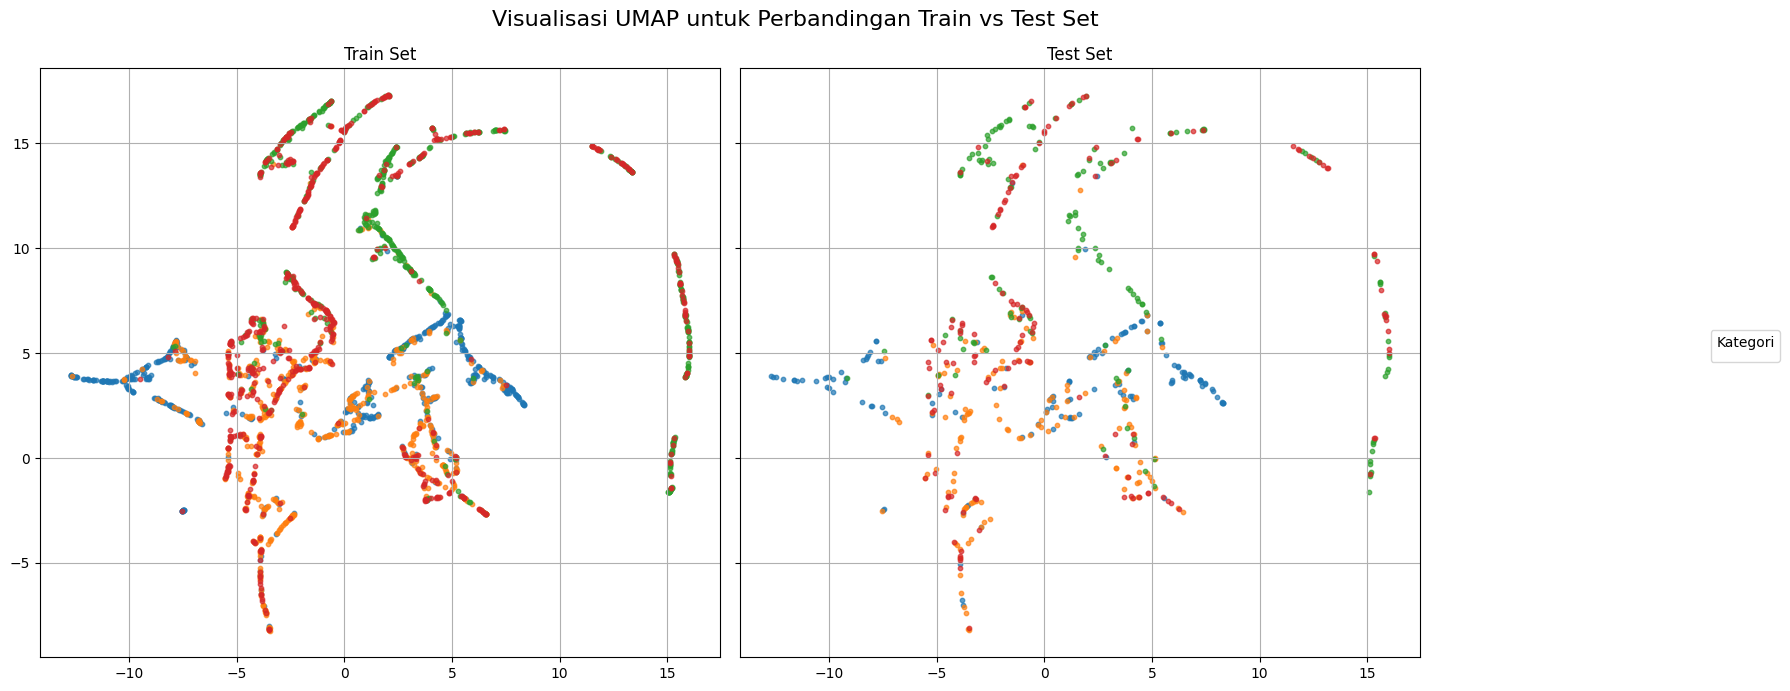


--- Selesai ---


In [19]:
## FASE 5: ANALISIS LANJUTAN DAN VISUALISASI (UMAP)

print("\n--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---")

# --- A. Siapkan Data untuk Visualisasi ---
labels = list(pd.Series(y_train).unique())
label_map = {label: i for i, label in enumerate(labels)}
y_train_numeric = pd.Series(y_train).map(label_map).values
y_test_numeric = pd.Series(y_test).map(label_map).values

# Gabungkan, skalakan, dan terapkan UMAP
X_combined = np.concatenate((X_train, X_test), axis=0)
X_scaled = StandardScaler().fit_transform(X_combined)
reducer = umap.UMAP(n_components=2, random_state=42)
X_2d_combined = reducer.fit_transform(X_scaled)
x2d_train = X_2d_combined[:len(X_train)]
x2d_test = X_2d_combined[len(X_train):]

# --- B. Fungsi untuk Menggambar Plot ---
def plot_topic_clusters(ax, x2d, y_numeric, labels, title):
    ax.set_title(title)
    colors = cm.get_cmap("Spectral", len(labels))
    for i, label_name in enumerate(labels):
        ax.scatter(x2d[y_numeric == i, 0], x2d[y_numeric == i, 1],
                   label=label_name, alpha=0.7, s=10)
    ax.grid(True)
    return ax

# --- C. Buat dan Tampilkan Dua Subplot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
plot_topic_clusters(axes[0], x2d_train, y_train_numeric, labels, "Train Set")
plot_topic_clusters(axes[1], x2d_test, y_test_numeric, labels, "Test Set")
fig.suptitle("Visualisasi UMAP untuk Perbandingan Train vs Test Set", fontsize=16)

# Tambahkan legenda di luar plot
handles, current_labels = axes[0].get_legend_handles_labels()
# Gunakan `num` untuk memastikan semua handle dibuat jika kategori banyak
handles, _ = axes[0].collections[0].legend_elements(num=len(labels))
fig.legend(handles, labels, title="Kategori", loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("\n--- Selesai ---")